This report compares *MF*, *[NeuMF](https://arxiv.org/pdf/1708.05031)*, and *NeuMF* with *[MMR](https://www.cs.cmu.edu/~jgc/publication/The_Use_MMR_Diversity_Based_LTMIR_1998.pdf)* postprocessing.

In [ ]:
import os
import json
import warnings
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

warnings.simplefilter(action="ignore", category=FutureWarning)

sns.set_style("whitegrid")
sns.set_palette("bright", 3)
plt.rc("axes.spines", top=False, right=False)

%load_ext pretty_jupyter

The pretty_jupyter extension is already loaded. To reload it, use:
  %reload_ext pretty_jupyter


## Data

We use two datasets throughout this report: *[interaction.json](https://github.com/radimvalis/neumf-evaluation/blob/main/data/interaction.json)* and *[movie_embeddings.json](https://github.com/radimvalis/neumf-evaluation/blob/main/data/movie_embeddings.json)*.

#### interaction.json

We exported this dataset from *EasyStudy* 's database. It contains logs collected from 4 participants who rated algorithms over 5 iteration rounds.

In [45]:
interactions_df = pd.read_json(os.path.join("data", "interaction.json"))
interactions_df = interactions_df.drop(columns=[ "time" ], axis=1)
interactions_df

,id,participation,interaction_type,data
0,1,1,loaded-page,"{""page"": ""preference_elicitation"", ""context"": ..."
1,2,1,on-input,"{""search_text_box_value"": ""prada"", ""context"": ..."
2,3,1,selected-item,"{""selected_item"": {""movieName"": ""Devil Wears P..."
3,4,1,changed-viewport,"{""viewport"": {""left"": 0, ""top"": 0, ""width"": 19..."
4,5,1,on-input,"{""search_text_box_value"": ""mama"", ""context"": {..."
...,...,...,...,...
982,983,4,on-input,"{""id"": """", ""text"": ""Finish user study"", ""name""..."
983,984,4,iteration-ended,"{""iteration"": 5, ""selected"": [[863, 782, 410, ..."
984,985,4,study-ended,"{""iteration"": 5}"
985,986,4,loaded-page,"{""page"": ""finished_user_study"", ""context"": {""u..."


#### movie_embeddings.json

This dataset was extracted from a fitted instance of a *(Diversified) NeuMF* model. It includes movie indices and corresponding embeddings.

In [46]:
embeddings_df = pd.read_json(os.path.join("data", "movie_embeddings.json"))
embeddings_df

,movie_idx,embedding
0,8,"[-0.3509312868, 0.4983599782, -0.4398425519, 0..."
1,11,"[-0.2118005604, 0.5521904826, -0.2603289783, 0..."
2,14,"[0.4236060381, -0.20633351800000002, 0.3214513..."
3,22,"[-0.2169035971, -0.1967662573, -0.0951324999, ..."
4,27,"[0.012238361900000001, 0.4552696049, -1.066598..."
...,...,...
1925,1845,"[2.9959914684, -2.3926167488, 3.2849636078, -1..."
1926,1800,"[2.6797120571, -2.3741538525, 3.2547850609, -0..."
1927,1913,"[2.6833255291, -2.5622787476, 3.0506663322, -1..."
1928,1917,"[2.4284744263, -2.4721214771, 3.5537872314, -1..."


## Preprocessing

In [47]:
algorithm_map = { "A": "NEUMF", "B": "NEUMF_DIVERSITY", "C": "MF" }

names = list(algorithm_map.keys())
algorithms = list(algorithm_map.values())

# Add information on which iteration given record belongs to

def set_iteration_number(row):

    if row["interaction_type"] in [ "iteration-started", "iteration-ended" ]:

        row["iteration"] = json.loads(row["data"])["iteration"]

    else:

        row["iteration"] = None

    return row

interactions_df = interactions_df.apply(set_iteration_number, axis=1)

# Add information on iteration number to remaining records

interactions_df["iteration"] = interactions_df.groupby(["participation"], sort=False)["iteration"].ffill()
interactions_df: pd.DataFrame = interactions_df.dropna(subset=[ "iteration" ])
interactions_df["iteration"] = interactions_df["iteration"].astype(int)
interactions_df

,id,participation,interaction_type,data,iteration
29,30,1,iteration-started,"{""iteration"": 1, ""movies"": {""A"": {""movies"": [{...",1
30,31,1,loaded-page,"{""page"": ""compare_algorithms"", ""context"": {""ur...",1
31,32,1,changed-viewport,"{""viewport"": {""left"": 0, ""top"": 0, ""width"": 19...",1
32,33,1,changed-viewport,"{""viewport"": {""left"": 0, ""top"": -25, ""width"": ...",1
33,34,1,changed-viewport,"{""viewport"": {""left"": 0, ""top"": -342, ""width"":...",1
...,...,...,...,...,...
982,983,4,on-input,"{""id"": """", ""text"": ""Finish user study"", ""name""...",5
983,984,4,iteration-ended,"{""iteration"": 5, ""selected"": [[863, 782, 410, ...",5
984,985,4,study-ended,"{""iteration"": 5}",5
985,986,4,loaded-page,"{""page"": ""finished_user_study"", ""context"": {""u...",5


## Evaluation

In the evaluation section, we are mainly interested in the level of diversity and its influence on the quality of recommendations, as diversification was the postprocessing step we included in our *NeuMF* model. But first, let’s address more general questions.

### How many selections did each algorithm attract?

To address this question, we need to perform the following steps first:

1. Filter out selected movies that were later deselected.
2. Count selections for each algorithm that recommended a selected movie, since the dataset always includes only one record of a movie selection, even if multiple algorithms recommended it.

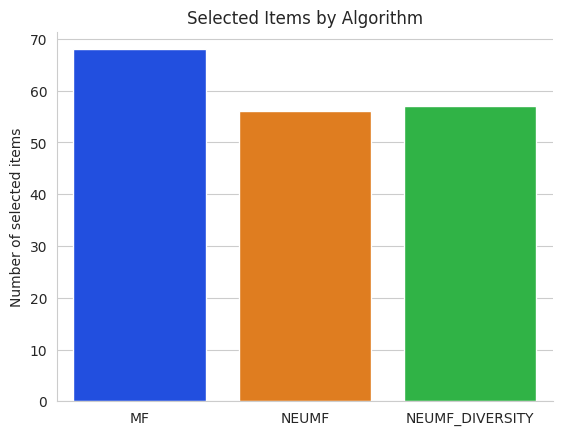

In [48]:
# Filter out selected items that were later deselected

sel_and_desel_items_df: pd.DataFrame = interactions_df[(interactions_df["interaction_type"] == "selected-item") | (interactions_df["interaction_type"] == "deselected-item")].copy()

def set_selected_item_idx(row):

    if row["interaction_type"] == "selected-item":

        row["movie_idx"] = json.loads(row["data"])["selected_item"]["movie_idx"]

    return row

def set_deselected_item_idx(row):

    if row["interaction_type"] == "deselected-item":

        row["movie_idx"] = json.loads(row["data"])["deselected_item"]["movie_idx"]

    return row

sel_and_desel_items_df = sel_and_desel_items_df.apply(set_selected_item_idx, axis=1)
sel_and_desel_items_df = sel_and_desel_items_df.apply(set_deselected_item_idx, axis=1)

deselected_item_rows_idxs = sel_and_desel_items_df[sel_and_desel_items_df["interaction_type"] == "deselected-item"].index

for i in deselected_item_rows_idxs:

    filter = (

        (sel_and_desel_items_df.index < i) &
        (sel_and_desel_items_df["participation"] == sel_and_desel_items_df.at[i, "participation"]) &
        (sel_and_desel_items_df["iteration"] == sel_and_desel_items_df.at[i, "iteration"]) &
        (sel_and_desel_items_df["movie_idx"] == sel_and_desel_items_df.at[i, "movie_idx"]) &
        (sel_and_desel_items_df["interaction_type"] == "selected-item")
    )
    
    sel_and_desel_items_df = sel_and_desel_items_df.drop(sel_and_desel_items_df[filter].index)

selected_items_df = sel_and_desel_items_df[sel_and_desel_items_df["interaction_type"] == "selected-item"].copy()

# Load lists of recommended items

iteration_started_df: pd.DataFrame = interactions_df[interactions_df["interaction_type"] == "iteration-started"].copy()

def set_recommended_items_idxs(row):

    data_as_json = json.loads(row["data"])

    for name in names:

        recommended_items_idxs = []

        for movie in data_as_json["movies"][name]["movies"]:

            recommended_items_idxs.append(movie["movie_idx"])

        row[algorithm_map[name]] = recommended_items_idxs

    return row

recommended_items_df = iteration_started_df.apply(set_recommended_items_idxs, axis=1)
recommended_items_df = recommended_items_df.drop(columns=[ "interaction_type", "data" ])

# Create DF with all selected items as selections in original dataset are counted only once, even if item is recommended by multiple algorithms

all_selections = []

for _, row in selected_items_df.iterrows():

    for algorithm in algorithms:

        if row["movie_idx"] in recommended_items_df.loc[(recommended_items_df["participation"] == row["participation"]) & (recommended_items_df["iteration"] == row["iteration"])].iloc[0][algorithm]:

            all_selections.append({ "participation": row["participation"], "iteration": row["iteration"], "movie_idx": row["movie_idx"], "algorithm": algorithm })

all_selected_items_df = pd.DataFrame(all_selections)

# Create figure

selections_counts = all_selected_items_df.groupby("algorithm")[["movie_idx"]].count().reset_index()

ax = sns.barplot(selections_counts, x="algorithm", y="movie_idx", hue="algorithm", legend=False)
ax.set(title="Selected Items by Algorithm", xlabel="", ylabel="Number of selected items")

plt.show()

In [49]:
%%jmd

We observe that *MF* attracted {{ selections_counts.iloc[0]["movie_idx"] }} selections, while *NeuMF* and *Diversified NeuMF* attracted only {{ selections_counts.iloc[1]["movie_idx"] }} and {{ selections_counts.iloc[2]["movie_idx"] }} selections, respectively.


We observe that *MF* attracted 68 selections, while *NeuMF* and *Diversified NeuMF* attracted only 56 and 57 selections, respectively.

### How did users rate recommendations?

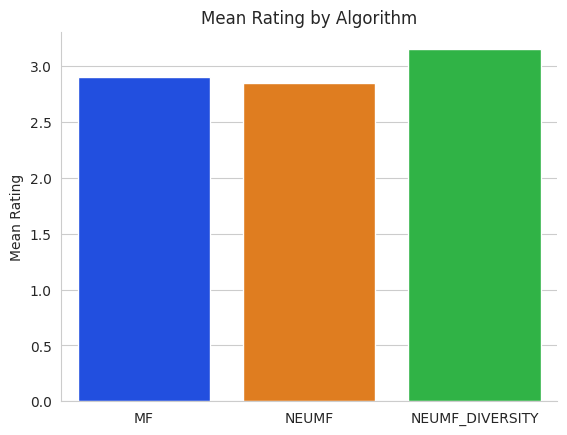

In [50]:
inputs_df = interactions_df.loc[interactions_df["interaction_type"] == "on-input"].copy()

def set_input_type(row):

    row["input_type"] = json.loads(row["data"])["input_type"]

    return row

inputs_df = inputs_df.apply(set_input_type, axis=1)

ratings_df: pd.DataFrame = inputs_df.loc[inputs_df["input_type"] == "rating"]

def set_rating_and_algorithm(row):

    data = json.loads(row["data"])

    row["rating"] = data["new_rating"]
    row["algorithm"] = algorithm_map[data["variant_name"]]

    return row

ratings_df = ratings_df.apply(set_rating_and_algorithm, axis=1)
ratings_df = ratings_df.drop_duplicates(subset=[ "participation", "iteration", "algorithm" ], keep="last")

# Create figure

ratings_means = ratings_df.groupby("algorithm")[["rating"]].mean().reset_index()

ax = sns.barplot(ratings_means, x="algorithm", y="rating", hue="algorithm", legend=False)
ax.set(title="Mean Rating by Algorithm", xlabel="", ylabel="Mean Rating")

plt.show()

The chart indicates that participants ranked all algorithms similarly.

### What's the diversity with respect to genres?

To measure the extent of diversity, we employ *[intra-list diversity](https://rectools.readthedocs.io/en/latest/api/rectools.metrics.diversity.IntraListDiversity.html)*, using the *[Jaccard index](https://en.wikipedia.org/wiki/Jaccard_index)* as a similarity metric.

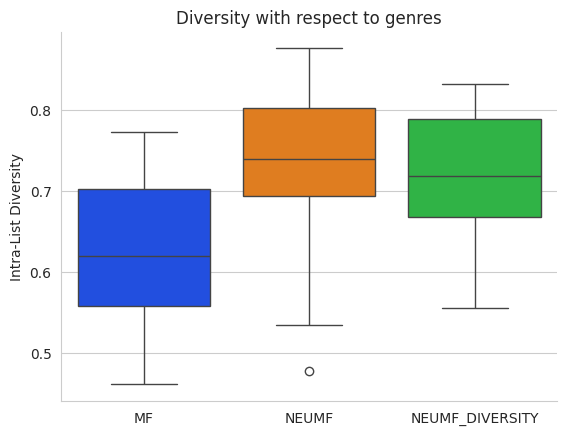

In [51]:
iteration_started_df = interactions_df.loc[interactions_df["interaction_type"] == "iteration-started"].copy()

def calculate_intra_list_diversity_by_genres(row):

    data = json.loads(row["data"])

    for name in names:

        genres_of_movies: list[set] = []

        for movie in data["movies"][name]["movies"]:

            genres = set(movie["genres"])

            if len(genres) > 0:

                genres_of_movies.append(genres)

        diversities_sum = 0

        for i, g1 in enumerate(genres_of_movies):
            for j, g2 in enumerate(genres_of_movies):

                    if i < j:

                        jaccard_similarity = len(g1.intersection(g2)) / len(g1.union(g2))

                        diversities_sum += 1 - jaccard_similarity

        pairs_count = len(genres_of_movies) * (len(genres_of_movies) - 1) / 2

        intra_list_diversity = diversities_sum / pairs_count

        row[algorithm_map[name] + "_ILD_genres"] = intra_list_diversity

    return row

iteration_started_df = iteration_started_df.apply(calculate_intra_list_diversity_by_genres, axis=1)

# Create figure

ax = sns.boxplot(data=iteration_started_df.rename(columns={ a + "_ILD_genres": a for a in algorithms })[sorted(algorithms)])
ax.set(title="Diversity with respect to genres", ylabel="Intra-List Diversity")

plt.show()

Firstly, both variants of *NeuMF* outperform *MF* in terms of genre diversity. Secondly, the median of *Diversified NeuMF* is less than the median of the basic version of *NeuMF*. This may be because diversification is performed based on movie embeddings, meaning that movie genres are not taken into account.

### What's the diversity with respect to embeddings?

Here, we recalculate *intra-list diversity* using movie embeddings. As a result, we replace the *Jaccard index*, suited for categorical data, with *[cosine similarity](https://en.wikipedia.org/wiki/Cosine_similarity)*, which is better for numerical vectors.

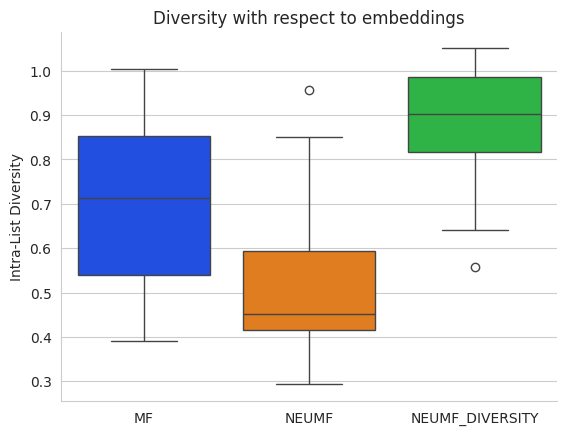

In [52]:
def calculate_intra_list_diversity_by_embeddings(row):

    data = json.loads(row["data"])

    for name in names:

        embeddings_of_movies = []

        for movie in data["movies"][name]["movies"]:

            embedding = embeddings_df.loc[embeddings_df["movie_idx"] == int(movie["movie_idx"])]["embedding"].to_numpy()[0]

            embeddings_of_movies.append(embedding)

        distances_sum = 0

        for i, e1 in enumerate(embeddings_of_movies):
            for j, e2 in enumerate(embeddings_of_movies):

                if i < j:

                    cosine_similarity = np.dot(e1, e2) / (np.linalg.norm(e1) * np.linalg.norm(e2))

                    distances_sum += 1 - cosine_similarity

        pairs_count = len(embeddings_of_movies) * (len(embeddings_of_movies) - 1) / 2

        intra_list_diversity = distances_sum / pairs_count

        row[algorithm_map[name] + "_ILD_embeddings"] = intra_list_diversity

    return row

iteration_started_df = iteration_started_df.apply(calculate_intra_list_diversity_by_embeddings, axis=1)

# Create figure

ax = sns.boxplot(data=iteration_started_df.rename(columns={ a + "_ILD_embeddings": a for a in algorithms })[sorted(algorithms)])
ax.set(title="Diversity with respect to embeddings", ylabel="Intra-List Diversity")

plt.show()

The result now looks as one would expect — recommendations provided by the diversified version of *NeuMF* are less uniform than those provided by the vanilla *NeuMF*. We can also see the importance of the postprocessing step — *NeuMF* alone doesn't outperform *MF*.

In [53]:
%%jmd

## Conclusion

To sum up, we first showed that all algorithms attracted about the same number of selections and that the overall quality of recommendations was also similar for all of them. Then, we investigated the algorithms in terms of diversity. We found that *Diversified NeuMF* recommended more diverse movies than *MF*, whether concerning genres or embeddings. As diversity is usually a desired property of a recommender, we can conclude that applying this kind of postprocessing to *NeuMF* makes sense. On the other hand, we base this conclusion on feedback from only {{ interactions_df["participation"].nunique() }} participants, so no one should take these results for granted.


## Conclusion

To sum up, we first showed that all algorithms attracted about the same number of selections and that the overall quality of recommendations was also similar for all of them. Then, we investigated the algorithms in terms of diversity. We found that *Diversified NeuMF* recommended more diverse movies than *MF*, whether concerning genres or embeddings. As diversity is usually a desired property of a recommender, we can conclude that applying this kind of postprocessing to *NeuMF* makes sense. On the other hand, we base this conclusion on feedback from only 4 participants, so no one should take these results for granted.